In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import anndata
import string
import gc
from anndata import read_h5ad
from anndata import read_csv
from pandas import DataFrame
import h5py
import os
import requests
import dill

/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


# Load Data

In [4]:
dill.load_session('sessions/005-gene_expression.pkl')

In [18]:
dill.dump_session('sessions/005-gene_expression.pkl')

In [2]:
# PATHS
SC_TRANSCRIPTOMICS_DIR = "singlecell_transcriptomics/TSP1_30_Paper2_Version2d_Oct2024/full_object"
METADATA = 'TSP1_30_metadata_min200_2500_decontx_scvi_donorassay_version2d_20241112.csv'
FULLDATA = 'TSP1_30_min200_2500_decontx_scvi_donorassay_version2d_20241126.h5ad'
DATA_DIR = os.path.join(os.getcwd(), '..', 'data/shared', SC_TRANSCRIPTOMICS_DIR)

# BOOLEANS
TenXOnly = True   # don't use plate data

In [3]:
adata = read_h5ad(os.path.join(DATA_DIR, FULLDATA))
adata

AnnData object with n_obs × n_vars = 1136218 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leiden', 'log1p', 'method_color

In [6]:
# Define the Ensembl REST API endpoint for BioMart
ENSEMBL_BIOMART_URL = "https://www.ensembl.org/biomart/martservice?query="

# XML query to retrieve human protein-coding genes
xml_query = """<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE Query>
<Query virtualSchemaName="default" formatter="TSV" header="1" uniqueRows="1" count="" datasetConfigVersion="0.6">
  <Dataset name="hsapiens_gene_ensembl" interface="default">
    <Filter name="biotype" value="protein_coding"/>
    <Attribute name="ensembl_gene_id"/>
    <Attribute name="external_gene_name"/>
    <Attribute name="chromosome_name"/>
    <Attribute name="start_position"/>
    <Attribute name="end_position"/>
  </Dataset>
</Query>
"""

# Make the API request
response = requests.get(ENSEMBL_BIOMART_URL + requests.utils.quote(xml_query))

# Check if request was successful
if response.status_code == 200:
    # Convert response text to a list of lines
    lines = response.text.strip().split('\n')
    # Convert to DataFrame
    data = [line.split('\t') for line in lines[1:]]  # Skip header
    columns = lines[0].split('\t')
    df = pd.DataFrame(data, columns=columns)
    
    # Save to CSV file
    df.to_csv('../data/human_protein_coding_genes.csv', index=False)
    print("Data saved to '../data/human_protein_coding_genes.csv'")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

df


Data saved to '../data/human_protein_coding_genes.csv'


# Label Genes w/r/t Protein Coding

In [66]:
# take both Ensembl gene ID and gene name as gene identifiers to be safe
protein_coding_gene_ids = set(df['Gene stable ID']).union(set(df['Gene name']))

# label genes as protein-coding or not
adata.var['is_protein_coding'] = adata.var['ensembl_id'].isin(protein_coding_gene_ids) | adata.var['gene_symbol'].isin(protein_coding_gene_ids)

# print useful information
print(f"Number of protein-coding genes: {sum(adata.var['is_protein_coding'])}")
print(f"Number of non-protein-coding genes: {sum(~adata.var['is_protein_coding'])}")
print(f"Number of genes without a label: {sum(adata.var['is_protein_coding'].isna())}")
print(f"Roughly number of protein-coding genes not found in TS: {len(protein_coding_gene_ids)/2 - sum(adata.var['is_protein_coding'])}")


Number of protein-coding genes: 19879
Number of non-protein-coding genes: 41927
Number of genes without a label: 0
Roughly number of protein-coding genes not found in TS: 1487.5


The genes not found Tabula Sapiens were probably not in the version of the reference genome used in cellranger. Therefore reads would have not been aligned to them and dropped out of the analysis prior to this and should be ignored here.

To include them in the analysis, raw reads would need to be aligned with a different procedure.

# Count Analysis of Protein Coding Genes

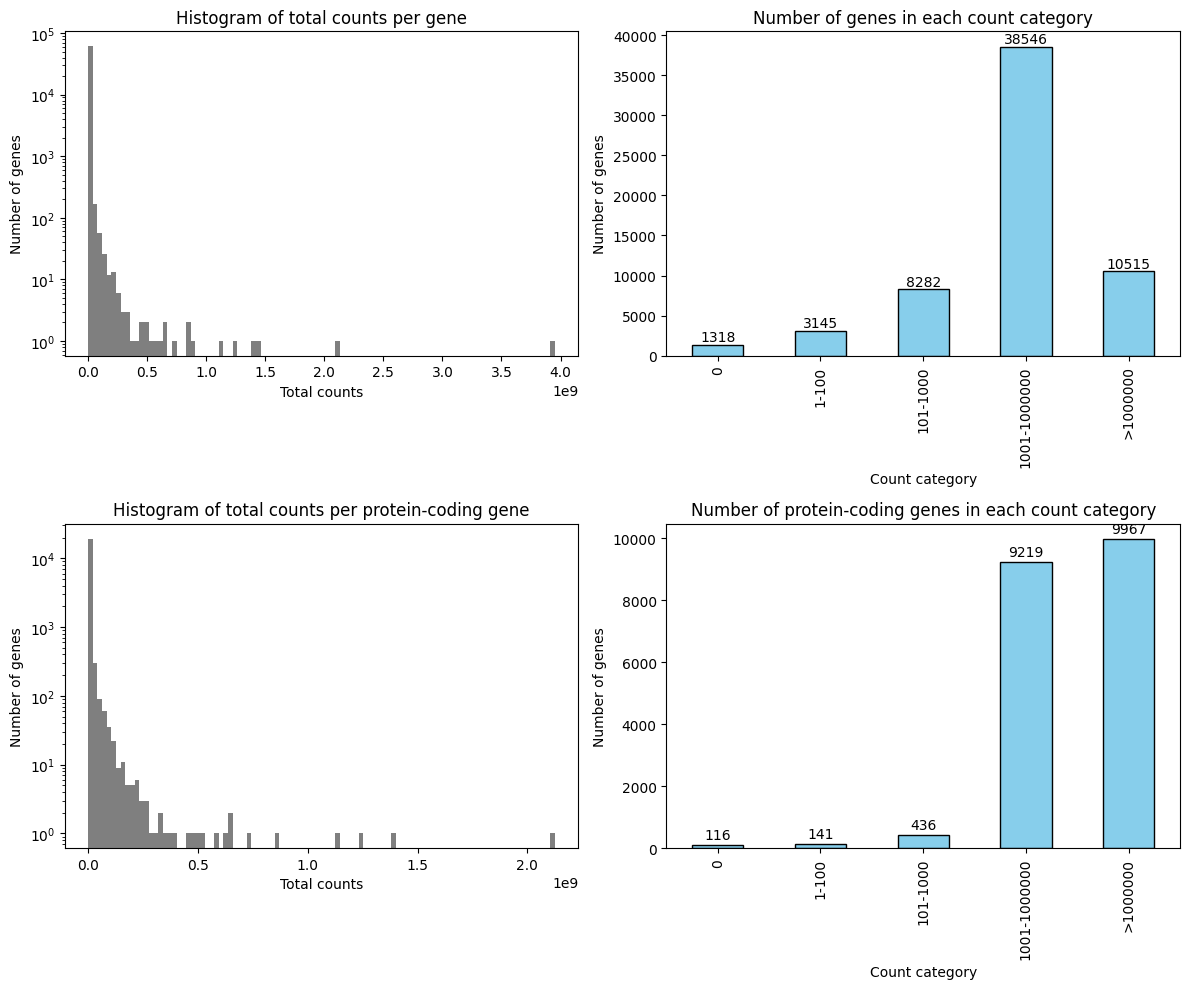

In [119]:
bins = [-1, 0, 100, 1000, 1000000, float('inf')]  # -1 ensures 0 is included in its own bin
labels = ['0', '1-100', '101-1000', '1001-1000000', '>1000000']
adata.var['count_category'] = pd.cut(adata.var['total_counts'], bins=bins, labels=labels)
category_counts = adata.var['count_category'].value_counts().sort_index()
protein_coding_counts = adata.var[adata.var['is_protein_coding']]['count_category'].value_counts().sort_index()

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms
adata.var['total_counts'].plot.hist(bins=100, color='black', alpha=0.5, label='All genes', ax=ax[0, 0], log=True)
adata.var[adata.var['is_protein_coding']]['total_counts'].plot.hist(bins=100, color='black', alpha=0.5, label='Protein-coding genes', ax=ax[1, 0], log=True)

# Plot bar charts
category_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax[0, 1])
protein_coding_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax[1, 1])

# Set titles and labels
ax[0, 0].set_title('Histogram of total counts per gene')
ax[0, 0].set_xlabel('Total counts')
ax[0, 0].set_ylabel('Number of genes')

ax[1, 0].set_title('Histogram of total counts per protein-coding gene')
ax[1, 0].set_xlabel('Total counts')
ax[1, 0].set_ylabel('Number of genes')

ax[0, 1].set_title('Number of genes in each count category')
ax[0, 1].set_xlabel('Count category')
ax[0, 1].set_ylabel('Number of genes')

ax[1, 1].set_title('Number of protein-coding genes in each count category')
ax[1, 1].set_xlabel('Count category')
ax[1, 1].set_ylabel('Number of genes')

# Add counts on top of bars
for i, v in enumerate(category_counts):
    ax[0, 1].text(i, v + 100, str(v), ha='center', va='bottom')
for i, v in enumerate(protein_coding_counts):
    ax[1, 1].text(i, v + 100, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Most genes have total counts across all cells between one thousand and one million. When only considering protein coding genes, the fraction of highly expressed genes with over one million counts is larger. This means that protein coding genes are on average more highly expressed than non protein coding genes. However, there are still 116 protein coding genes that have 0 total counts across all cells. 

# Analysis of Not Expressed Protein Coding Genes

In [141]:
adata[:, adata.var['is_protein_coding'] & (adata.var['count_category'] == '0')].var

,ensembl_id,gene_symbol,genome,mt,ercc,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mean,std,is_protein_coding,count_category
index,,,,,,,,,,,,,
GDF1,ENSG00000130283.9,GDF1,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
HNRNPA1L2,ENSG00000139675.13,HNRNPA1L2,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
PYURF,ENSG00000145337.5,PYURF,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
OR5M9,ENSG00000150269.1,OR5M9,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
OPN1MW2,ENSG00000166160.9,OPN1MW2,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000289762,ENSG00000289762.1,ENSG00000289762,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
ENSG00000289763,ENSG00000289763.1,ENSG00000289763,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0
ENSG00000289764,ENSG00000289764.1,ENSG00000289764,Gencode_v41,False,False,0,0.0,100.0,0.0,0.0,1.0,True,0


Manual annotation of first 10:

| Symbol    | Name                                                  | Function                                  | Note                  |
| --------- | ----------------------------------------------------- | ----------------------------------------- | --------------------- |
| GDF1      | Growth Differentiation Factor 1                       | Involved in early embryogenesis           | Reasonable: Timepoint |
| HNRNPA1L2 | Heterogeneous Nuclear Ribonucleoprotein A1 Like 2     | Part of spliceosome                       | Surprising            |
| PYURF     | PIGY Upstream Open Reading Frame                      | Mitochondrial Chaperone                   | Surprising            |
| OR5M9     | Olfactory Receptor Family 5 Subfamily M Member 9      | Olfactory Receptor                        | Reasonable: Tissue    |
| OPN1MW2   | Opsin 1, Medium Wave Sensitive 2                      | Light absorping visual pigment            | Surprising            |
| PPP2R3B   | Protein Phosphatase 2 Regulatory Subunit B''Beta      | Substrate specifity for phosphatase       | Surprising            |
| ASMTL     | Acetylserotonin O-Methyltransferase Like              | Nucleoside triphosphate pyrophosphatase   | Surprising            |
| SLC25A6   | Solute Carrier Family 25 Member 6                     | Translocation of ADP/ATP into/out of mt   | Surprising            |
| GTPBP6    | GTP Binding Protein 6 (Putative)                      | GTP binding (located on X/Y chr)          | Surprising            |
| P2RY8     | G-Protein Coupled Purinergic Receptor P2Y8            | Purinergic signaling (located on X/Y chr) | Surprising            |

In [145]:
genes = adata[:, adata.var['is_protein_coding'] & (adata.var['count_category'] == '0')].var['gene_symbol'].values
genes[:10]

['GDF1', 'HNRNPA1L2', 'PYURF', 'OR5M9', 'OPN1MW2', 'PPP2R3B', 'ASMTL', 'SLC25A6', 'GTPBP6', 'P2RY8']
Categories (115, object): ['AKAP17A', 'ASMT', 'ASMTL', 'BPY2', ..., 'USP17L28', 'USP17L29', 'USP17L30', 'UTP14C']